# ปัญหาการจำแนกประเภทดอกไอริส

ในคาบที่ผ่านมา ได้นำเสนอการทำนายค่า Sepal length จากคุณลักษณะอื่น ๆ อีก 3 คุณลักษณะ ได้แก่ Sepal width, Petal width และ Petal length สำหรับในคาบนี้ หากเราเปลี่ยนเป้าหมาย (target) ของการทำนายให้เป็นประเภทของดอก ที่มี 3 สายพันธ์บ้างล่ะ เราจะทำอย่างไร

**จุดประสงค์การเรียนรู้**
1. เข้าใจว่าทำไมถึงไม่ควรใช้ Linear regression ทำนายประเภทดอกไอริส
2. เข้าใจที่มาของการ Logistic regression ที่ต่อยอดมาจาก Linear regression
3. สามารถใช้ LabelEncoder ในการแปลงสิ่งที่ต้องการทำนายที่ไม่ใช่ตัวเลข ให้เป็นตัวเลขได้
4. สามารถใช้ Logistic regression ในการแก้ปัญหา Binary classification กรณีที่อินพุตมีแค่ 1 คุณลักษณะ
5. สามารถประเมินประสิทธิภาพโมเดล Logistic regression ด้วยค่า Accuracy และ Confusion matrix

ก่อนอื่น อ่านข้อมูลดอกไอริสเข้ามาก่อนเหมือนเช่นเคย

In [4]:
!wget -c "https://archive.ics.uci.edu/static/public/53/iris.zip" -O iris.zip
!unzip -o iris.zip -d iris_data

import pandas as pd
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris = pd.read_csv('iris_data/iris.data',
                   header=None,
                   names=column_names)
iris.info()

--2024-01-23 07:21:00--  https://archive.ics.uci.edu/static/public/53/iris.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘iris.zip’

iris.zip                [ <=>                ]   3.65K  --.-KB/s    in 0s      

2024-01-23 07:21:00 (540 MB/s) - ‘iris.zip’ saved [3738]

Archive:  iris.zip
  inflating: iris_data/Index         
  inflating: iris_data/bezdekIris.data  
  inflating: iris_data/iris.data     
  inflating: iris_data/iris.names    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    floa

ค่าที่ต้องการทำนายคือคอลัมน์ class ซึ่งมีค่าที่เป็นไปได้ คือ

In [5]:
iris['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

เราเรียกค่าเหล่านี้ว่า **target** (ที่ต้องการทำนาย) เช่นในคาบก่อนที่เราเรียก Sepal length ว่าเป็น target แต่สำหรับกรณีของคาบนี้ ค่า target เป็นไปได้แค่ 3 แบบเท่านั้น จึงอาจมันเรียกว่า **class** หรือ **label** ก็ได้

เราเรียกปัญหาการจำแนกประเภทดอกไม้ว่า ปัญหา **Classification** ซึ่งต่างจากปัญหา Regression ที่เราใช้เรียกปัญหาการทำนายค่า Sepal length ในคาบที่ผ่านมา ซึ่งทั้งสองปัญหานี้ต่างกันอย่างไร?

- **ปัญหา Regression** คือปัญหาที่สิ่งที่ต้องการทำนายเป็น**จำนวนจริง**
- **ปัญหา Classification** คือปัญหาที่สิ่งที่ต้องการทำนายเป็น**จำนวนเต็ม**

อันที่จริง ปัญหา 2 ประเภทนี้ มีความเกี่ยวข้องกัน ยกตัวอย่างเช่น
- ปัญหาของการทำนาย Sepal length ที่เป็น Regression ก็สามารถแปลงเป็นปัญหา Classification ได้ หากเราแบ่งค่า Sepal length ให้เป็นช่วง ๆ (เช่น สั้นมาก/สั้น/ปานกลาง/ยาว/ยาวมาก เป็นต้น) แล้วให้โมเดลทำนายว่าดอก ๆ หนึ่งมีค่า Sepal length ตกอยู่ในระดับใด
- ปัญหาของการทำนายประเภทดอกที่เป็นไปได้ 3 แบบ ซึ่งเป็นปัญหา Classification ก็อาจมองเป็นปัญหาการทำนายค่าความน่าจะเป็น (ซึ่งเป็นค่าทศนิยม มีค่าในช่วง 0 ถึง 1) ของการเป็นดอกประเภทใดประเภทหนึ่ง ซึ่งเป็นปัญหา Regression





สำหรับปัญหาในคาบนี้ จะเริ่มที่ปัญหาการจำแนก (Classification) สายพันธ์ให้เป็น 2 สายพันธ์ (Binary classification) แล้วจะค่อยแก้ปัญหากรณี 3 สายพันธ์ (Multi-class classification)

> **Note:** ปัญหาการจำแนกกรณีที่มีเพียง 2 classes เราจะเรียกมันว่า Binary classification แต่หากมี class ตั้งแต่ 3 classes ขึ้นไป เราจะเรียกรวม ๆ ว่า Multi-class classification



## Binary classification with only 1 input feature

เพื่อที่จะมองปัญหาให้ง่ายที่สุด เราจะเริ่มต้นปัญหาการจำแนกระหว่างดอกพันธุ์ Setosa กับ Versicolor โดยจะใช้คุณลักษณะ sepal width เป็นอินพุต (ตัวแปรต้น) เท่านั้น และเราจะลองใช้ Linear regression แบบโต้ง ๆ เป็นโมเดลในการทำนาย



In [6]:
# filter data เฉพาะที่จะใช้
iris2 = iris.loc[(iris['class'] == 'Iris-setosa') | (iris['class'] == 'Iris-versicolor'), ['sepal_width','class']].copy()
iris2  # อย่าลืม copy เพราะไม่งั้นถ้าแก้ iris2 แล้วค่าใน iris ต้นฉบับจะเปลี่ยนด้วย (แต่เรายังต้องการใช้ต้นฉบับภายหลังอีก)

,sepal_width,class
0,3.5,Iris-setosa
1,3.0,Iris-setosa
2,3.2,Iris-setosa
3,3.1,Iris-setosa
4,3.6,Iris-setosa
...,...,...
95,3.0,Iris-versicolor
96,2.9,Iris-versicolor
97,2.9,Iris-versicolor
98,2.5,Iris-versicolor


จากข้อมูล `iris2` ลองแบ่ง train/test และทำการ Standardize ข้อมูล เพื่อใช้ทำการทดลองต่อไป

In [7]:
from sklearn.model_selection import train_test_split
iris2_train, iris2_test = train_test_split(iris2, train_size=0.7, random_state=888)

จากการแบ่งข้างต้น ลองวาดกราฟของข้อมูล `iris2_train` ดู จะเห็น `Iris-versicolor` อยู่ฝั่งซ้าย และ `Iris-setosa` อยู่ฝั่งขวาของแกนนอน

In [8]:
import plotly.express as px
px.scatter(iris2_train, x='sepal_width', y='class', color='class')

ข้อสังเกตจากกราฟคือ Plotly สามารถแสดงแกนตั้งของกราฟได้ (`Iris-setosa` กับ `Iris-versicolor`) แม้ว่าค่าของแกนตั้งจะไม่ใช่ตัวเลขก็ตาม

อย่างไรก็ตาม สำหรับการเทรนโมเดล Linear regression นั้น (รวมถึงโมเดลอื่น ๆ อีกมากในโลกนี้) ก็จะไม่สามารถทำได้ หากไม่แปลง String เป็นตัวเลขเสียก่อน

สมมติว่ากำหนดให้

- `Iris-setosa` แทนด้วน `0`
- `Iris-versicolor` แทนด้วย `1`

เราอาจเขียนโค้ดแบบด้านล่างนี้ เพื่อแทน String ด้วยตัวเลขก็ได้ แล้วจึงค่อยป้อนค่าเข้า Linear regression

```
iris2 = iris2.replace({'Iris-setosa':0, 'Iris-versicolor':1})
```
แต่กระนั้น ในตัวอย่างนี้เราจะไม่ทำ แต่จะลองใช้ตัวแปลงชนิดข้อมูลของ Scikit-learn ที่เรียกว่า `LabelEncoder` ([คู่มือ](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)) ซึ่งนำเข้าและสร้างตัวแปรที่เป็นตัวกลางในการแปลงชนิดข้อมูล ดังนี้







In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

สำหรับวิธีการใช้งาน จะคล้ายกับ `StandardScaler` และ `MinMaxScaler` จากคาบที่ผ่านมา ดังนี้

In [10]:
le.fit(iris2_train['class'])
print(le.classes_)

['Iris-setosa' 'Iris-versicolor']


ซึ่งหลังจาก `.fit()` แล้ว LabelEncoder จะจำรายการของ class ไว้ ในกรณีนี้คือ `['Iris-setosa' 'Iris-versicolor']`

และเมื่อใช้คำสั่ง `.transform()` จะทำให้แต่ละ class ถูกกำหนดค่าตัวเลข ดังนี้

- `Iris-setosa` จะมีค่า 0 เพราะอยู่ตำแหน่ง index=0 ของ List
- `Iris-versicolor` จะมีค่า 1 เพราะอยู่ตำแหน่ง index=1 ของ List

In [11]:
y_train = le.transform(iris2_train['class'])
y_test = le.transform(iris2_test['class'])
print('y_train =', y_train)   # จะเห็นว่าตอนนี้มีแต่ 0 กับ 1
print('y_test =', y_test)     # จะเห็นว่าตอนนี้มีแต่ 0 กับ 1
sum(y_train == 1)

y_train = [1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0
 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0]
y_test = [1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1]


33

หรือหากต้องการแปลงกลับเพื่อการแสดงผล หรือเพื่อประโยชน์ในการอ้างถึงภายหลัง  ก็ทำได้เช่นกัน โดยใช้ `.inverse_transform()` เช่น

In [12]:
le.inverse_transform([1,1,0,0,1])

array(['Iris-versicolor', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa',
       'Iris-versicolor'], dtype=object)

ที่ผ่านมาเป็นการแปลงเฉพาะส่วนของ target ที่จะนำไปสอนโมเดล จาก String เป็นตัวเลข

ดังนั้น เราจะทำการแปลงข้อมูลส่วนที่เป็นอินพุตด้วย (เหมือนในคาบที่ผ่านมา) ด้วยการทำ Standardization ก่อนที่จะทำการเทรนโมเดล

In [13]:
X_train = iris2_train[['sepal_width']]  # X ต้องเป็น DataFrame ที่แต่ละแถวคือ 1 ดอก
X_test = iris2_test[['sepal_width']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # ทำทั้ง fit (คำนวณ mean และ sd) และ transform (แปลงค่า)
X_test = scaler.transform(X_test) # transform โดยใช้ค่าที่ fit ไว้แล้ว

### ลองใช้ Linear regression ในการแก้ปัญหา Classification

เมื่อ Standardize ข้อมูลแล้ว ก็จะทำการเทรนโมเดล โดยลองเอาข้อมูล training set มาทำนายตัวมันเอง ดังโค้ดต่อไปนี้ ซึ่งในโค้ด ได้วาดกราฟแต่ละจุดแสดงผลการทำนายจาก Linear regression ส่วนสีของจุด แสดงถึงค่าที่แท้จริงของ (สีน้ำเงิน=1=Iris-setosa, สีแดง=0=Iris-versicolor)

In [14]:
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
fig = px.scatter(x=X_train.squeeze(),  # X_train.squeeze() เพื่อลดมิติจาก 2D เป็น 1D เนื่องจาก px.scatter ต้องการ 1D
                 y=y_train_pred,
                 color=y_train.astype(str),
                 opacity=0.5,
                 labels={'x':'Standardized sepal width (x)', 'y':'สายพันธุ์ที่ทำนายได้ (y^)', 'color':'ค่าสายพันธุ์ที่แท้จริง'},
                 title='กราฟแสดงผลการทำนายสายพันธ์จากค่า Sepal width')

fig.add_hline(y=0.65)

จากกราฟ สิ่งที่ Linear regression ทำนายได้ เป็นค่าจำนวนจริง ดังนั้น การจะตีความให้ได้ 0 (Setosa) หรือ 1 (Versicolor) นั้นจะทำได้อย่างไร นักศึกษาอาจตอบว่า ในเมื่อสีของจุดที่แสดงกำกับอยู่ แสดงถึงกลุ่มที่ถูกต้อง ก็แค่ใช้เส้น $y=0.65$ (เส้นแนวนอน) ในการแบ่งกลุ่มเสียเลย

คำตอบข้างต้นก็เป็นคำตอบที่สมเหตุสมผลดี อย่างไรก็ตาม วิธีการเช่นนั้นมีข้อจำกัด เพราะค่า $y=0.65$ นั้น เราเลือกมาเองจากการกะด้วยสายตา มันคงจะดีกว่านี้ถ้าเราไม่ต้องมาเลือกขีดแบ่ง (threshold) เอง

กราฟข้างต้นแสดงถึงปัญหาของตัวโมเดล Linear regression ที่ตัวโมเดลเองเหมาะสมกับการทำนายค่าจำนวนจริง แต่กลับนำมาทำนายเป้าหมายที่เป็นไปได้แค่ 2 ค่า คือ 0 กับ 1 หรือจะกล่าวอีกอย่างก็คือ โมเดล Linear regression นั้น ไม่เหมาะสมกับปัญหา Classification (อ้าว แล้วที่ทำมาตั้งแต่เริ่มบทล่ะ...) ดังนั้น เราควรที่จะเปลี่ยนรูปแบบโมเดล



### Logistic regression ในการแก้ปัญหา Classification

โมเดลเชิงเส้นที่เหมาะสมกับปัญหา Classification คือ โมเดลที่เรียกว่า Logistic regression โดยที่มาของโมเดลนั้น เป็นการต่อยอดมาจาก Linear regression

จากกราฟที่ผ่านมาด้านบน ที่แสดงถึงปัญหาของ Linear regression ที่เอาต์พุตของมันเป็นจำนวนจริง แต่ค่าที่เราต้องการทำนายมีค่าแค่ 0 กับ 1 ดังนั้นจึงเกิดแนวคิดที่ว่า นำเอาต์พุตของ Linear regression ไปผ่านฟังก์ชันสักอย่างหนึ่ง ที่บีบค่าให้อยู่ในช่วง 0 ถึง 1 เท่านั้น ซึ่งฟังก์ชันที่มีคุณสมบัติดังกล่าว และเป็นที่นิยมใช้ คือฟังก์ชัน sigmoid ที่มีสมการและกราฟ ดังนี้

$$
\mathrm{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$$

ซึ่งจะเห็นว่า เมื่อส่งค่าอะไรให้ฟังก์ชัน $\mathrm{sigmoid}(z)$ ก็จะไม่มีทางมากกว่า 1 หรือน้อยกว่า 0 โดยที่ $z=0$ จะมีค่า $\mathrm{sigmoid}(z)=0.5$ ซึ่งเป็นตัวแบ่งครึ่งแกนตั้งพอดี

In [15]:
# ตัวอย่างกราฟเฉย ๆ นักศึกษาสามารถข้ามโค้ดส่วนนี้ได้เลย
import numpy as np
z = np.linspace(-8,8,200)
sigma = 1/(1+np.exp(-z))
px.line(x=z, y=sigma,labels={'x':'z','y':'sigmoid(z)'})

จากเดิม โมเดล Simple linear regression มีสมการ

$$
\hat{y} = w x + b
$$

เมื่อต้องการบีบ $\hat{y}$ ให้อยู่ในช่วง 0 ถึง 1 ก็ใช้ฟังก์ชัน sigmoid ช่วง ซึ่งจะได้สมการของโมเดลใหม่ ดังนี้
$$
\hat{y} = \mathrm{sigmoid}(w x + b)
$$

สมการใหม่นี้ ยังคงเข้ากับรูปแบบปัญหาของ Linear regression ที่ว่า

$$
\min_{w,b} \frac{1}{n} \sum_{i=1}^n (\hat{y}^{(i)} - y^{(i)})^2
$$
โดยที่ $\hat{y}^{(i)} = \mathrm{sigmoid}(w x^{(i)} + b)$

อย่างไรก็ตาม ในทางทฤษฎีพบว่า การวัดความผิดพลาดของผลการทำนาย $(\hat{y} - y)$ ด้วย MSE นั้น ให้ผลไม่ดีนักต่อการหาค่า $w$ และ $b$ ที่ดีที่สุด ดังนั้น นักคณิตศาสตร์จึงเสนอให้ใช้ฟังก์ชันวัดความผิดพลาดอีกฟังก์ชันหนึ่งที่ดีกว่า ที่เรียกว่า ฟังก์ชัน **Cross entropy loss** ซึ่งในที่นี้จะไม่ขอลงรายละเอียด แต่จะเขียนแทนฟังก์ชันดังกล่าวว่า $\mathrm{Loss}(\hat{y}, y)$ สุดท้ายแล้ว จึงได้รูปแบบของปัญหาทางคณิตศาสตร์ ดังนี้

$$
\min_{w,b} \frac{1}{n} \sum_{i=1}^n \mathrm{Loss}(\hat{y}^{(i)}, y^{(i)})
$$
โดยที่ $\hat{y}^{(i)} = \mathrm{sigmoid}(w x^{(i)} + b)$

เราเรียกการแก้ปัญหาการหา $w$ และ $b$ ของฟังก์ชัน $\hat{y} = \mathrm{sigmoid}(w x + b)$ ที่ให้ค่า $\mathrm{Loss}(\hat{y}, y)$ เฉลี่ยต่ำที่สุด นี้ว่า **Logistic regression**


แล้วค่า $w$ และ $b$ ที่ว่า จริง ๆ แล้ว จะหาได้อย่างไร เป็นเรื่องของวิชา Optimization ซึ่งเป็นศาสตร์ของการหาค่าที่ดีที่สุด อย่างไรก็ตาม จะขอข้ามการอธิบายวิธีการคำนวณไปก่อน (ตอนเนื้อหา Linear regression ก็ข้ามไปแล้ว และตอนนีก็ขอผัดผ่อนไปอีก) โดยจะใช้คำสั่ง `LogisticRegression()` ของ Scikit-learn ในการคำนวณค่าที่ดีที่สุดให้แทน

การเรียก `LogisticRegression` จาก Scikit-learn เพื่อมาทำการเทรน ทำได้ดังนี้

In [16]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()   # ใช้รูปแบบเดียวกับ LinearRegression เลย
model.fit(X_train, y_train)    # เทรนโมเดล

LogisticRegression()

In [17]:
w = model.coef_
b = model.intercept_
c = model.classes_
print(f'w = {w.squeeze()}, b = {b.squeeze()}')  # squeeze เพื่อลดมิติของค่า เช่น [[-2.1629]] ลดเหลือ -2.1629
print(f'list of classes = {c.tolist()}')

w = -2.162910505141291, b = -0.21613484019218462
list of classes = [0, 1]


หลังจากตรวจสอบค่าสัมประสิทธิ์ พบว่าได้สมการ

$$
\hat{y} = \frac{1}{1+e^{- (w x + b) }} = \frac{1}{1+e^{2.16291051 x  + 0.21613484 }}
$$
เมื่อลองวาดกราฟเทียบกับ training set ที่สร้างมันขึ้นมา และผลการทำนาย จะได้ดังรูป

In [18]:
# โค้ดนี้สำหรับวาดกราฟ อาจข้ามไปดูกราฟได้เลย
import numpy as np

def sigmoid(z):
  return 1/(1+np.exp(-z.squeeze()))

fig = px.scatter(x=X_train.squeeze(),  # X_train.squeeze() เพื่อลดมิติจาก 2D เป็น 1D เนื่องจาก px.scatter ต้องการ 1D
                 y=y_train,
                 color=y_train.astype(str),
                 opacity=0.5,
                 labels={'x':'Standardized sepal width (x)', 'y':'สายพันธุ์ที่ทำนายได้ (y^)', 'color':''},
                 title='กราฟแสดง training set กับเส้นกราฟของ Logistic regression')
fig.add_trace(
    go.Scatter(x=X_train.squeeze(),
               y=sigmoid(w*X_train+b),  # คำนวณสมการ Logistic regression เองกับมือ เมื่อป้อน X_train เข้าไป
               mode='markers',name='ค่าที่ทำนายได้')
)

x = np.linspace(-2.5,2.5,200)
fig.add_trace(
    go.Scatter(x=x,
               y=sigmoid(w*x+b),  # คำนวณสมการ Logistic regression เองกับมือ เพื่อวาดกราฟเส้น
               mode='lines', name='โมเดล Logistic regression',
               line = dict(shape='linear', color='rgb(205,12,24)', width= 1, dash='dash'))
)
fig.add_hline(y=0.5)

จากกราฟจะเห็น

- จุดสีแดง (0; `Iris-setosa`) และน้ำเงิน (1; `Iris-versicolor`) คือสายพันธุ์ที่แท้จริงของดอกใน training set
- เส้นประสีแดง เป็นเส้นกราฟที่วาดจากสมการที่มีสัมประสิทธิ์ที่ได้จากการเทรน `LogisticRegression`
- จุดสีเขียว เป็นค่าที่ได้จากการป้อนดอกใน training set เข้าสมการเส้นประสีแดง
- เส้น $y=0.5$ คือเส้นแบ่งครึ่งระหว่างดอกสายพันธุ์ 0 และสายพันธุ์ 1 โดยเราสามารถใช้ค่านี้ในการตัดสินใจได้
  - ถ้าหากจุดเขียวอยู่เกินเส้น $y=0.5$ ก็จะหมายถึง `Iris-versicolor`
  - ถ้าหากจุดเขียวอยู่ต่ำกว่าเส้น $y=0.5$ ก็จะหมายถึง `Iris-setosa`

การที่เอาต์พุตของ Logistic regression มีค่าในช่วง 0 ถึง 1 เท่านั้น เราสามารถตีความเอาต์พุตเป็นค่าความน่าจะเป็น (probability) ของการที่ดอกที่อินพุต จะเป็นสายพันธุ์ 1 (`Iris-versicolor`)  ดังนิยาม

$$
\mathbb{P}(y = 1 \mid x) = \hat{y} = \frac{1}{1+e^{- (w x + b) }}
$$

ซึ่งจากค่าความน่าจะเป็น การตัดสินใจว่าดอกจะเป็นดอกสายพันธุ์ไหน ก็ตัดสินใจด้วยกฎการตัดสินใจ (Decision rule) ดังนี้

$$
\mathbb{P}(y = 1 \mid x) > 0.5 ⟹ \mathrm{Prediction} = 1  
$$
$$
\mathbb{P}(y = 1 \mid x) \leq 0.5 ⟹ \mathrm{Prediction} = 0  
$$
โดยสัญลักษณ์ $\mathbb{P}$ คือความน่าจะเป็น และสัญลักษณ์ $\mid x$ แสดงเพื่อบอกว่า เป็นความน่าจะเป็นเมื่อป้อน $x$ เป็นอินพุต

ทั้งนี้ เนื่องจากมีแค่ 2 classes คือ 0 กับ 1 จึงหมายความว่า หากสนใจความน่าจะเป็นที่ $y=0$ แล้วล่ะก็ ก็สามารถนำ 1 มาลบ
$$
\mathbb{P}(y = 0 \mid x) = 1 - \mathbb{P}(y = 1 \mid x)
$$

ยกตัวอย่างเช่น หากโมเดลทำนายว่า ดอก ๆ หนึ่ง น่าจะเป็นชนิด 1 ด้วยความน่าจะเป็น 0.8 ก็หมายความว่า ดอก ๆ นั้น มีความน่าจะเป็นชนิด 0 อยู่เท่ากับ 0.2 เป็นต้น


#### การใช้ `model.predict()`

จากโมเดลที่เทรนแล้ว เราจะลองใช้คำสั่ง `model.predict()` จะพบว่า ผลการทำนายเป็นแค่ค่า 0 หรือ 1 ไม่เหมือนกับจุดสีเขียวที่แสดงในกราฟก่อนหน้า ที่เป็นค่าความน่าจะเป็น สาเหตุที่เป็นเช่นนั้น ก็เพราะ `model.predict()` ใช้เส้น $y=0.5$ ในการปัดขึ้นหรือปัดลง



In [19]:
y_train_pred = model.predict(X_train)
y_train_pred = pd.Series(y_train_pred, index=iris2_train.index)

#### การใช้ `model.predict_proba()`

ถ้าหากต้องการให้โมเดล `LogisticRegression` ของ Scikit-learn ให้ผลลัพธ์เป็นค่าความน่าจะเป็น จะต้องใช้ `model_predict_proba()` แทน ซึ่งค่าความน่าจะเป็น จะเป็นประโยชน์ในแง่ของการแสดงความเชื่อมั่นของโมเดล ว่ามั่นใจว่าเป็นสายพันธ์ไหน เช่นหากได้ $P(y=1\mid x)$ = 0.98 แสดงว่าโมเดลมั่นใจ 98% ว่าเป็นสายพันธุ์ 1 เป็นต้น



In [20]:
y_train_pred_proba = model.predict_proba(X_train) # ได้ Numpy array
y_train_pred_proba = pd.DataFrame(
    y_train_pred_proba,
    columns=['P(y=0|x)', 'P(y=1|x)'],
    index=iris2_train.index
) # เราทำเป็น DataFrame จะได้ดูผลง่าย ๆ ซึ่งเราอาจจะนำไปจัดอันดับดอก ตามความน่าจะเป็นก็ได้
y_train_pred_proba

,P(y=0|x),P(y=1|x)
68,0.019491,0.980509
6,0.832435,0.167565
39,0.832435,0.167565
21,0.951812,0.048188
24,0.832435,0.167565
...,...,...
17,0.887262,0.112738
60,0.007858,0.992142
46,0.969032,0.030968
22,0.925750,0.074250


### การประเมินประสิทธิภาพของโมเดล Logistic Regression

ใน Linear regression เราใช้ MSE เป็นเป้าหมาย (Objective) ในการหาพารามิเตอร์ของโมเดล รวมถึงการรายงานประสิทธิภาพของโมเดลให้ผู้อื่นได้รับทราบ อย่างไรก็ตาม สำหรับ Logistic regression กลับใช้ Cross entropy loss ด้วยเหตุผลของทางเทคนิคในการฝีกสอนโมเดล ซึ่งเป็นฟังก์ชันวัดประสิทธิภาพที่ผู้คนโดยทั่วไปไม่เข้าใจ ดังนั้น ในการรายงานประสิทธิภาพของโมเดล Logistic regression จึงจะใช้ค่าอื่นแทน ได้แก่

1. Accuracy
2. Confusion matrix

สำหรับค่าอื่น ๆ ได้แก่ค่า Precision, Recall, F1-score เป็นต้น ซึ่งจะยังไม่ขอกล่าวในหัวข้อนี้

#### การคำนวณ Accuracy

การคำนวณ Accuracy ของโมเดล คำนวณได้จาก

$$
\mathrm{Accuracy} = \frac{n_\mathrm{correct}}{n_\mathrm{correct} + n_\mathrm{incorrect}} = \frac{n_\mathrm{correct}}{n}
$$

โดยที่ $n_\mathrm{correct}$ และ $n_\mathrm{incorrect}$ คือจำนวนที่ทายถูกและผิด ตามลำดับ ส่วน $n$ คือข้อมูลที่นำมาทำนายทั้งหมด

หากจะคำนวณเองด้วย Pandas จะทำได้ดังนี้

In [21]:
correct = (y_train == y_train_pred)  # อย่าลืมว่าตัวแปร y_train_pred มีแต่ค่า 0 กับ 1
correct.mean() # หรือ correct.sum()/len(correct)

0.8428571428571429

หรือหากจะใช้ Scikit-learn ก็ย่อมได้ โดยทำดังนี้

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_train_pred)

0.8428571428571429


#### การคำนวณ Confusion matrix

ค่า Accuracy เป็นการเปรียบเทียบความถูกต้องของการทำนายเพียงด้านเดียว กล่าวคือ ค่า Accuracy สะท้อนสัดส่วนเฉพาะกรณีที่ผลค่าที่ทำนายตรงกับค่าที่แท้จริงเท่านั้น อย่างไรก็ตาม เราไม่อาจทราบได้ว่า กรณีที่ทำนายผิด เป็นการผิดในลักษณะใด กล่าวคือ

- ค่าจริงเป็น 0 แต่โมเดลทำนาย 1
- ค่าจริงเป็น 1 แต่โมเดลทำนาย 0 เป็นต้น

ดังนั้น จึงมีประเมินประสิทธิภาพอีกอย่างหนึ่ง คือ Confusion matrix ที่สามารถคำนวณได้โดยใช้ `confusion_matrix` ของ Scikit-learn ([คู่มือ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)) ซึ่งมีวิธีใช้คือ




In [23]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)

[[31  6]
 [ 5 28]]


โดย

- แต่ละแถวคือเป็นค่าที่แท้จริง และ
- คอลัมน์แสดงค่าที่ทำนายได้

เช่น ค่า 5 หมายถึง ดอกที่แท้จริงเป็นสายพันธุ์ 1 แต่โมเดลทำนายเป็นสายพันธุ์ 0 เป็นต้น

ซึ่งเพื่อไม่ให้สับสนระหว่างแถวกับคอลัมน์ อาจใช้ฟังก์ชัน `ConfusionMatrixDisplay` ของ Scikit-learn ในการช่วยแสดงผล Confusion matrix ก็ได้ ซึ่งจะได้กราฟที่วาดด้วยไลบรารี Matplotlib

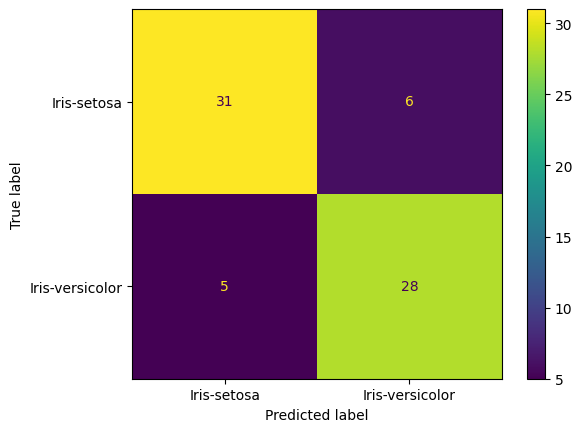

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion,   # ได้จาก confusion_matrix
    display_labels=le.inverse_transform(model.classes_),  # model.classes_ เก็บ [0,1] ไว้ จึงใช้ LabelEncoder แปลงกลับเป็นชื่อสายพันธุ์
)
disp.plot()


อย่างไรก็ตาม เพื่อความสวยงาม นักศึกษาอาจลองหัดวาดเองโดยใช้ Plotly โดยใช้กราฟประเภท Heat map ([คู่มือ](https://plotly.com/python/heatmaps/)) ซึ่งสามารถวาดด้วยคำสั่ง `px.imshow()` (imshow ย่อมาจาก Image show เพื่อแสดงรูป)

In [37]:
# ใช้สร้างเป็น DataFrame เพื่อที่จะให้ imshow แสดงชื่อ index และชื่อคอลัมน์
df_confusion = pd.DataFrame(confusion,
                            index=le.inverse_transform(model.classes_),
                            columns=le.inverse_transform(model.classes_))
df_confusion

,Iris-setosa,Iris-versicolor
Iris-setosa,31,6
Iris-versicolor,5,28


In [42]:
fig = px.imshow(df_confusion,
          labels=dict(x='ค่าที่ทำนาย', y='ค่าที่แท้จริง', color='ค่าสี'),
          text_auto=True)
fig.update_xaxes(side="top")  # เอาคำอธิบายแกนนอนไว้ด้านบน



> **ข้อสังเกต:** ฟังก์ชันการคำนวณประสิทธิภาพของโมเดล ไม่ว่าจะเป็น `confusion_matrix`, `accuracy_score`, และ `mean_squared_error`  จะถูกนิยามไว้ใน `sklearn.metrics` ดังนั้น ที่ผ่านมา จึงเห็นเรานำเข้าฟังก์ชันเหล่านี้จาก `sklearn.metrics`

> **ระวัง:** ฟังก์ชันวัดประสิทธิภาพของ Scikit-learn จะรับค่าที่ถูกต้อง (Ground truth) กับค่าผลการทำนาย (Prediction) ตามลำดับ เพื่อนำไปคำนวณประสิทธิภาพ ดังนั้น ระวังอย่าสลับตำแหน่งการส่งค่า เพราะจะทำให้ผลการคำนวณผิดพลาด หากฟังก์ชันวัดประสิทธิภาพนั้นไม่มีคุณสมบัติสลับที่ อย่างเช่น `confusion_matrix`

### สรุปโค้ด Logistic regression

ในส่วนท้ายของการใช้ Logistic regression เพื่อแก้ปัญหา Binary classification  ด้านล่างนี้ ได้รวบรวมโค้ดทั้งหมดตั้งแต่ต้น จนถึงการรายงานประสิทธิภาพโมเดล

In [83]:
%reset -f
import pandas as pd
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris = pd.read_csv('iris_data/iris.data',
                   header=None,
                   names=column_names)

######################
# ส่วนของการเตรียมข้อมูล #
######################
iris2 = iris.loc[(iris['class'] == 'Iris-setosa') | (iris['class'] == 'Iris-versicolor'), ['sepal_width','class']].copy()

# Train/Test split
from sklearn.model_selection import train_test_split
iris2_train, iris2_test = train_test_split(iris2, train_size=0.7, random_state=888)

# LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(iris2_train['class'])
y_test = le.transform(iris2_test['class'])

# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = iris2_train[['sepal_width']]  # X ต้องเป็น DataFrame ที่แต่ละแถวคือ 1 ดอก
X_test = iris2_test[['sepal_width']]
X_train = scaler.fit_transform(X_train)  # ทำทั้ง fit (คำนวณ mean และ sd) และ transform (แปลงค่า)
X_test = scaler.transform(X_test) # transform โดยใช้ค่าที่ fit ไว้แล้ว

#############################
# ส่วนของโมเดลและการเทรนโมเดล #
#############################
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()   # ใช้รูปแบบเดียวกับ LinearRegression เลย
model.fit(X_train, y_train)    # เทรนโมเดล

##################
# ส่วนของการทำนาย #
##################
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

##################
# ส่วนของการประเมิน #
##################
from sklearn.metrics import accuracy_score
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# วาดกราฟ confusion matrix
import plotly.express as px
class_names = le.inverse_transform(model.classes_)
cm_train = pd.DataFrame(cm_train, index=class_names, columns=class_names)
cm_test = pd.DataFrame(cm_test, index=class_names, columns=class_names)

fig = px.imshow(cm_train,
          labels=dict(x='ค่าที่ทำนาย', y='ค่าที่แท้จริง', color='ค่าสี'),
          title='Confusion matrix ของ training set', width=400, height=400,
          text_auto=True)
fig.show()

fig = px.imshow(cm_test,
          labels=dict(x='ค่าที่ทำนาย', y='ค่าที่แท้จริง', color='ค่าสี'),
          title='Confusion matrix ของ test set', width=400, height=400,
          text_auto=True)
fig.show()

print(f'Accuracy of training set = {100*acc_train:.3f}%')
print(f'Accuracy of test set = {100*acc_test:.3f}%')


Accuracy of training set = 84.286%
Accuracy of test set = 83.333%


## ลองทำ: Binary classification with > 1 input features

สรุปโค้ด Logistic regression ที่ให้ ใช้เพียงแค่ 1 คุณลักษณะเป็นอินพุตเท่านั้น จะเห็นว่าได้ผลลัพธ์ได้ดีพอประมาณ

```
Accuracy of training set = 84.286%
Accuracy of test set = 83.333%
```

ดังนั้น ในส่วนสุดท้ายนี้ จะขอให้นักศึกษาทดลองแก้ไขโค้ดดังกล่าว ดังนี้

- **แบบที่ 1:** ให้รับอินพุตมากกว่า 1 คุณลักษณะ คือ `sepal_width` และ `petal_width` เพื่อจำแนกระหว่างสายพันธุ์ Setosa กับ Versicolor
- **แบบที่ 2:** รับ `sepal_width` และ `sepal_length` เพื่อจำแนกระหว่างสายพันธุ์ Virginica กับ Versicolor

*เมื่อทดลองแล้ว ให้รายงานค่า Accuracy ของ Training set และ Test set และตอบคำถามอีกว่า ทำไมแบบที่ 1* ถึงได้ผลการจำแนกถูกต้อง 100%



สำหรับในหัวข้อต่อจากนี้ จะเป็นการแก้ปัญหา Multi-class classification เพื่อจำแนกดอกไอริส 3 สายพันธุ์ (ไม่ใช่แค่ 2 สายพันธุ์เหมือนในบทนี้)